In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [25]:

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Custom dataset to handle both images and segmentation masks
class OxfordPetsSegmentation(Dataset):
    def __init__(self, root='./data', split='trainval', transform=None, target_transform=None):
        self.dataset = OxfordIIITPet(
            root=root,
            split=split,
            target_types='segmentation',
            download=True
        )
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, target = self.dataset[idx]
        
        # Convert segmentation mask: 1 for pet, 2 for background, 3 for border
        # We'll convert to binary: 1 for pet, 0 for background
        
        # Convert PIL Image to numpy array first
        if isinstance(target, Image.Image):
            target = np.array(target)
        
        # Now create binary mask (1 for pet, 0 for background)
        mask = (target == 1).astype(np.float32)
        
        # Convert to PIL Image for transforms if needed
        mask_pil = Image.fromarray(mask)
        
        # Apply transforms if specified
        if self.transform:
            image = self.transform(image)
        
        # Apply target transforms if specified
        if self.target_transform:
            mask = self.target_transform(mask_pil)
        else:
            # If no target transform, convert to tensor directly
            mask = torch.from_numpy(mask).float().unsqueeze(0)  # Add channel dimension
        
        return image, mask

Using device: cuda


In [26]:
# UNet implementation with shape comments
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()
        
        # Encoder (Contracting Path)
        # Shape: (batch, channels, height, width)
        
        # Level 1 (Input: 3 channels -> 32 features)
        # Input: (batch, 3, H, W)
        # Output: (batch, 32, H, W)
        self.encoder1 = UNet._block(in_channels, init_features, name="enc1")
        # After pool: (batch, 32, H/2, W/2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Level 2 (32 -> 64 features)
        # Input: (batch, 32, H/2, W/2)
        # Output: (batch, 64, H/2, W/2)
        self.encoder2 = UNet._block(init_features, init_features * 2, name="enc2")
        # After pool: (batch, 64, H/4, W/4)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Level 3 (64 -> 128 features)
        # Input: (batch, 64, H/4, W/4)
        # Output: (batch, 128, H/4, W/4)
        self.encoder3 = UNet._block(init_features * 2, init_features * 4, name="enc3")
        # After pool: (batch, 128, H/8, W/8)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Level 4 (128 -> 256 features)
        # Input: (batch, 128, H/8, W/8)
        # Output: (batch, 256, H/8, W/8)
        self.encoder4 = UNet._block(init_features * 4, init_features * 8, name="enc4")
        # After pool: (batch, 256, H/16, W/16)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bottleneck (256 -> 512 features)
        # Input: (batch, 256, H/16, W/16)
        # Output: (batch, 512, H/16, W/16)
        self.bottleneck = UNet._block(init_features * 8, init_features * 16, name="bottleneck")
        
        # Decoder (Expansive Path)
        # Each level: concat(upsampled_features, skip_connection) -> conv
        
        # Level 4 up (512 + 256 -> 256 features)
        # Input to upconv: (batch, 512, H/16, W/16)
        # Output from upconv: (batch, 256, H/8, W/8)
        self.upconv4 = nn.ConvTranspose2d(
            init_features * 16, init_features * 8, kernel_size=2, stride=2
        )
        # After concat: (batch, 512, H/8, W/8) [256 from upconv + 256 from enc4]
        self.decoder4 = UNet._block((init_features * 8) * 2, init_features * 8, name="dec4")
        
        # Level 3 up (256 + 128 -> 128 features)
        # Input to upconv: (batch, 256, H/8, W/8)
        # Output from upconv: (batch, 128, H/4, W/4)
        self.upconv3 = nn.ConvTranspose2d(
            init_features * 8, init_features * 4, kernel_size=2, stride=2
        )
        # After concat: (batch, 256, H/4, W/4) [128 from upconv + 128 from enc3]
        self.decoder3 = UNet._block((init_features * 4) * 2, init_features * 4, name="dec3")
        
        # Level 2 up (128 + 64 -> 64 features)
        # Input to upconv: (batch, 128, H/4, W/4)
        # Output from upconv: (batch, 64, H/2, W/2)
        self.upconv2 = nn.ConvTranspose2d(
            init_features * 4, init_features * 2, kernel_size=2, stride=2
        )
        # After concat: (batch, 128, H/2, W/2) [64 from upconv + 64 from enc2]
        self.decoder2 = UNet._block((init_features * 2) * 2, init_features * 2, name="dec2")
        
        # Level 1 up (64 + 32 -> 32 features)
        # Input to upconv: (batch, 64, H/2, W/2)
        # Output from upconv: (batch, 32, H, W)
        self.upconv1 = nn.ConvTranspose2d(
            init_features * 2, init_features, kernel_size=2, stride=2
        )
        # After concat: (batch, 64, H, W) [32 from upconv + 32 from enc1]
        self.decoder1 = UNet._block(init_features * 2, init_features, name="dec1")
        
        # Final 1x1 convolution to get output channels
        # Input: (batch, 32, H, W)
        # Output: (batch, 1, H, W)
        self.conv = nn.Conv2d(
            in_channels=init_features, out_channels=out_channels, kernel_size=1
        )
    
    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=features,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        # Input shape: (batch, 3, H, W)
        
        # Encoder
        # Level 1
        enc1 = self.encoder1(x)  # (batch, 32, H, W)
        enc1_pool = self.pool1(enc1)  # (batch, 32, H/2, W/2)
        
        # Level 2
        enc2 = self.encoder2(enc1_pool)  # (batch, 64, H/2, W/2)
        enc2_pool = self.pool2(enc2)  # (batch, 64, H/4, W/4)
        
        # Level 3
        enc3 = self.encoder3(enc2_pool)  # (batch, 128, H/4, W/4)
        enc3_pool = self.pool3(enc3)  # (batch, 128, H/8, W/8)
        
        # Level 4
        enc4 = self.encoder4(enc3_pool)  # (batch, 256, H/8, W/8)
        enc4_pool = self.pool4(enc4)  # (batch, 256, H/16, W/16)
        
        # Bottleneck
        bottleneck = self.bottleneck(enc4_pool)  # (batch, 512, H/16, W/16)
        
        # Decoder
        # Level 4 up
        dec4 = self.upconv4(bottleneck)  # (batch, 256, H/8, W/8)
        dec4 = torch.cat((dec4, enc4), dim=1)  # (batch, 512, H/8, W/8)
        dec4 = self.decoder4(dec4)  # (batch, 256, H/8, W/8)
        
        # Level 3 up
        dec3 = self.upconv3(dec4)  # (batch, 128, H/4, W/4)
        dec3 = torch.cat((dec3, enc3), dim=1)  # (batch, 256, H/4, W/4)
        dec3 = self.decoder3(dec3)  # (batch, 128, H/4, W/4)
        
        # Level 2 up
        dec2 = self.upconv2(dec3)  # (batch, 64, H/2, W/2)
        dec2 = torch.cat((dec2, enc2), dim=1)  # (batch, 128, H/2, W/2)
        dec2 = self.decoder2(dec2)  # (batch, 64, H/2, W/2)
        
        # Level 1 up
        dec1 = self.upconv1(dec2)  # (batch, 32, H, W)
        dec1 = torch.cat((dec1, enc1), dim=1)  # (batch, 64, H, W)
        dec1 = self.decoder1(dec1)  # (batch, 32, H, W)
        
        # Final output
        return torch.sigmoid(self.conv(dec1))  # (batch, 1, H, W)

In [27]:

# Dice coefficient for evaluation
def dice_coefficient(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

# IoU (Jaccard Index) for evaluation
def iou_score(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, scheduler=None):
    train_losses = []
    val_losses = []
    val_dices = []
    val_ious = []
    
    best_val_dice = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for images, masks in train_bar:
            images = images.to(device)
            masks = masks.to(device)
            
            # Ensure masks have the right shape [batch_size, 1, H, W]
            if len(masks.shape) == 3:
                masks = masks.unsqueeze(1)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            
            # Update progress bar
            train_bar.set_postfix({'loss': loss.item()})
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_iou = 0.0
        
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for images, masks in val_bar:
                images = images.to(device)
                masks = masks.to(device)
                
                # Ensure masks have the right shape
                if len(masks.shape) == 3:
                    masks = masks.unsqueeze(1)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                dice = dice_coefficient(outputs, masks)
                iou = iou_score(outputs, masks)
                
                val_loss += loss.item() * images.size(0)
                val_dice += dice.item() * images.size(0)
                val_iou += iou.item() * images.size(0)
                
                # Update progress bar
                val_bar.set_postfix({'loss': loss.item(), 'dice': dice.item()})
        
        # Calculate epoch statistics
        train_loss = train_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        val_dice = val_dice / len(val_loader.dataset)
        val_iou = val_iou / len(val_loader.dataset)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_dices.append(val_dice)
        val_ious.append(val_iou)
        
        # Learning rate scheduling
        if scheduler:
            scheduler.step(val_loss)
        
        print(f"\nEpoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f}")
        print(f"  Val Dice: {val_dice:.4f}")
        print(f"  Val IoU: {val_iou:.4f}")
        
        # Save best model
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': val_dice,
                'val_iou': val_iou,
            }, 'best_unet_model.pth')
            print(f"  ✓ Saved best model with Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")
    
    return train_losses, val_losses, val_dices, val_ious


In [28]:

# Visualization function
def visualize_results(model, dataloader, num_samples=3):
    model.eval()
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    
    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            if i >= num_samples:
                break
                
            images = images.to(device)
            masks = masks.to(device)
            
            # Ensure masks have the right shape
            if len(masks.shape) == 3:
                masks = masks.unsqueeze(1)
            
            outputs = model(images)
            pred_masks = (outputs > 0.5).float()
            
            # Calculate Dice for this sample
            dice = dice_coefficient(outputs, masks).item()
            
            # Denormalize image for visualization
            mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
            std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
            img_denorm = images * std + mean
            img_denorm = torch.clamp(img_denorm, 0, 1)
            
            # Convert tensors to numpy for plotting
            img = img_denorm[0].cpu().permute(1, 2, 0).numpy()
            true_mask = masks[0, 0].cpu().numpy()
            pred_mask = pred_masks[0, 0].cpu().numpy()
            
            # Create overlay
            overlay = img.copy()
            overlay[pred_mask > 0.5] = [1, 0, 0]  # Red for prediction
            
            # Plot
            axes[i, 0].imshow(img)
            axes[i, 0].set_title('Input Image')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(true_mask, cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(pred_mask, cmap='gray')
            axes[i, 2].set_title(f'Prediction (Dice: {dice:.3f})')
            axes[i, 2].axis('off')
            
            axes[i, 3].imshow(overlay)
            axes[i, 3].set_title('Overlay')
            axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.savefig('unet_predictions.png', dpi=100, bbox_inches='tight')
    plt.show()

# Plot training history
def plot_training_history(train_losses, val_losses, val_dices, val_ious):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
    
    epochs = range(1, len(train_losses) + 1)
    
    ax1.plot(epochs, train_losses, label='Train Loss', marker='o')
    ax1.plot(epochs, val_losses, label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(epochs, val_dices, label='Val Dice', color='green', marker='^')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Dice Coefficient')
    ax2.set_title('Validation Dice Coefficient')
    ax2.legend()
    ax2.grid(True)
    
    ax3.plot(epochs, val_ious, label='Val IoU', color='purple', marker='d')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('IoU Score')
    ax3.set_title('Validation IoU Score')
    ax3.legend()
    ax3.grid(True)
    
    ax4.plot(epochs, train_losses, label='Train Loss', alpha=0.5)
    ax4.plot(epochs, val_dices, label='Val Dice', alpha=0.5)
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Value')
    ax4.set_title('Loss vs Dice Comparison')
    ax4.legend()
    ax4.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=100, bbox_inches='tight')
    plt.show()

Loading datasets...
Training samples: 2944
Validation samples: 736
Test samples: 3669
Batch size: 16

Model Architecture:
UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-

Epoch 1/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 21.80it/s, loss=0.333, dice=0.732]



Epoch 1/20:
  Train Loss: 0.4456
  Val Loss: 0.3647
  Val Dice: 0.7083
  Val IoU: 0.5669
  ✓ Saved best model with Dice: 0.7083, IoU: 0.5669


Epoch 2/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 22.96it/s, loss=0.302, dice=0.787]



Epoch 2/20:
  Train Loss: 0.3513
  Val Loss: 0.3229
  Val Dice: 0.7522
  Val IoU: 0.6199
  ✓ Saved best model with Dice: 0.7522, IoU: 0.6199


Epoch 3/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 23.00it/s, loss=0.26, dice=0.828] 



Epoch 3/20:
  Train Loss: 0.2986
  Val Loss: 0.2743
  Val Dice: 0.7917
  Val IoU: 0.6712
  ✓ Saved best model with Dice: 0.7917, IoU: 0.6712


Epoch 4/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 22.12it/s, loss=0.225, dice=0.844]



Epoch 4/20:
  Train Loss: 0.2686
  Val Loss: 0.2396
  Val Dice: 0.8133
  Val IoU: 0.7006
  ✓ Saved best model with Dice: 0.8133, IoU: 0.7006


Epoch 5/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 22.59it/s, loss=0.209, dice=0.834]



Epoch 5/20:
  Train Loss: 0.2472
  Val Loss: 0.2420
  Val Dice: 0.7960
  Val IoU: 0.6811


Epoch 6/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 22.00it/s, loss=0.23, dice=0.83]  



Epoch 6/20:
  Train Loss: 0.2253
  Val Loss: 0.2386
  Val Dice: 0.8063
  Val IoU: 0.6948


Epoch 7/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 22.87it/s, loss=0.198, dice=0.854]



Epoch 7/20:
  Train Loss: 0.2142
  Val Loss: 0.2095
  Val Dice: 0.8422
  Val IoU: 0.7406
  ✓ Saved best model with Dice: 0.8422, IoU: 0.7406


Epoch 8/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 22.58it/s, loss=0.18, dice=0.858] 



Epoch 8/20:
  Train Loss: 0.1976
  Val Loss: 0.1992
  Val Dice: 0.8338
  Val IoU: 0.7307


Epoch 9/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 22.37it/s, loss=0.18, dice=0.848] 



Epoch 9/20:
  Train Loss: 0.1851
  Val Loss: 0.2105
  Val Dice: 0.8182
  Val IoU: 0.7107


Epoch 10/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 22.46it/s, loss=0.218, dice=0.856]



Epoch 10/20:
  Train Loss: 0.1733
  Val Loss: 0.2085
  Val Dice: 0.8446
  Val IoU: 0.7459
  ✓ Saved best model with Dice: 0.8446, IoU: 0.7459


Epoch 11/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 22.34it/s, loss=0.18, dice=0.851] 



Epoch 11/20:
  Train Loss: 0.1663
  Val Loss: 0.1992
  Val Dice: 0.8486
  Val IoU: 0.7515
  ✓ Saved best model with Dice: 0.8486, IoU: 0.7515


Epoch 12/20 [Val]: 100%|██████████| 46/46 [00:01<00:00, 23.19it/s, loss=0.202, dice=0.871]



Epoch 12/20:
  Train Loss: 0.1592
  Val Loss: 0.2311
  Val Dice: 0.8415
  Val IoU: 0.7408


Epoch 13/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 22.85it/s, loss=0.183, dice=0.88] 



Epoch 13/20:
  Train Loss: 0.1492
  Val Loss: 0.1948
  Val Dice: 0.8577
  Val IoU: 0.7644
  ✓ Saved best model with Dice: 0.8577, IoU: 0.7644


Epoch 14/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 22.74it/s, loss=0.18, dice=0.875] 



Epoch 14/20:
  Train Loss: 0.1353
  Val Loss: 0.1857
  Val Dice: 0.8586
  Val IoU: 0.7655
  ✓ Saved best model with Dice: 0.8586, IoU: 0.7655


Epoch 15/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 21.97it/s, loss=0.2, dice=0.859]  



Epoch 15/20:
  Train Loss: 0.1348
  Val Loss: 0.1855
  Val Dice: 0.8646
  Val IoU: 0.7745
  ✓ Saved best model with Dice: 0.8646, IoU: 0.7745


Epoch 16/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 22.40it/s, loss=0.162, dice=0.878]



Epoch 16/20:
  Train Loss: 0.1222
  Val Loss: 0.1830
  Val Dice: 0.8682
  Val IoU: 0.7801
  ✓ Saved best model with Dice: 0.8682, IoU: 0.7801


Epoch 17/20 [Val]: 100%|██████████| 46/46 [00:01<00:00, 23.08it/s, loss=0.158, dice=0.885]



Epoch 17/20:
  Train Loss: 0.1141
  Val Loss: 0.1797
  Val Dice: 0.8674
  Val IoU: 0.7786


Epoch 18/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 22.79it/s, loss=0.167, dice=0.872]



Epoch 18/20:
  Train Loss: 0.1164
  Val Loss: 0.1881
  Val Dice: 0.8656
  Val IoU: 0.7761


Epoch 19/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 22.94it/s, loss=0.158, dice=0.881]



Epoch 19/20:
  Train Loss: 0.1156
  Val Loss: 0.1818
  Val Dice: 0.8658
  Val IoU: 0.7766


Epoch 20/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 22.54it/s, loss=0.184, dice=0.877]



Epoch 20/20:
  Train Loss: 0.1041
  Val Loss: 0.2128
  Val Dice: 0.8565
  Val IoU: 0.7635


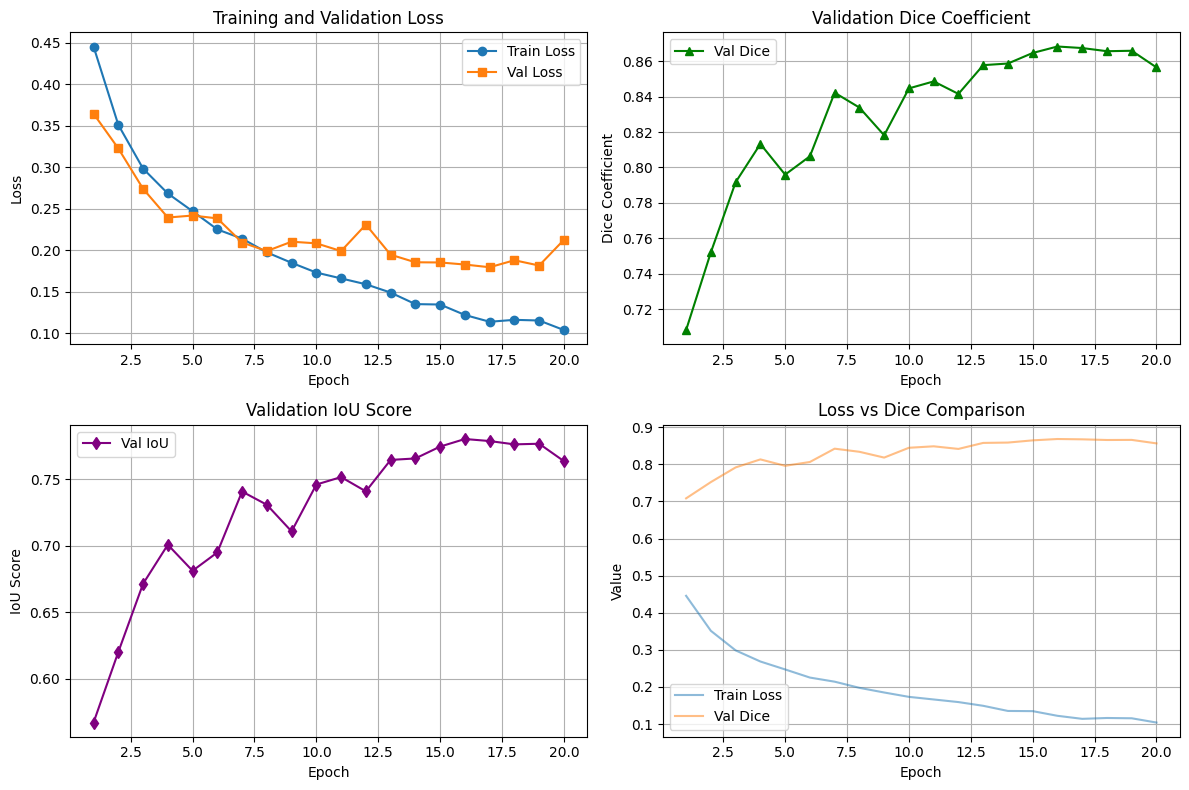


Loaded best model from epoch 16
Best validation Dice: 0.8682
Best validation IoU: 0.7801

Testing on test set...


Testing: 100%|██████████| 230/230 [00:10<00:00, 22.66it/s, loss=0.221, dice=0.815] 



Test Results:
  Test Loss: 0.1962
  Test Dice: 0.8591
  Test IoU: 0.7700

Visualizing results...


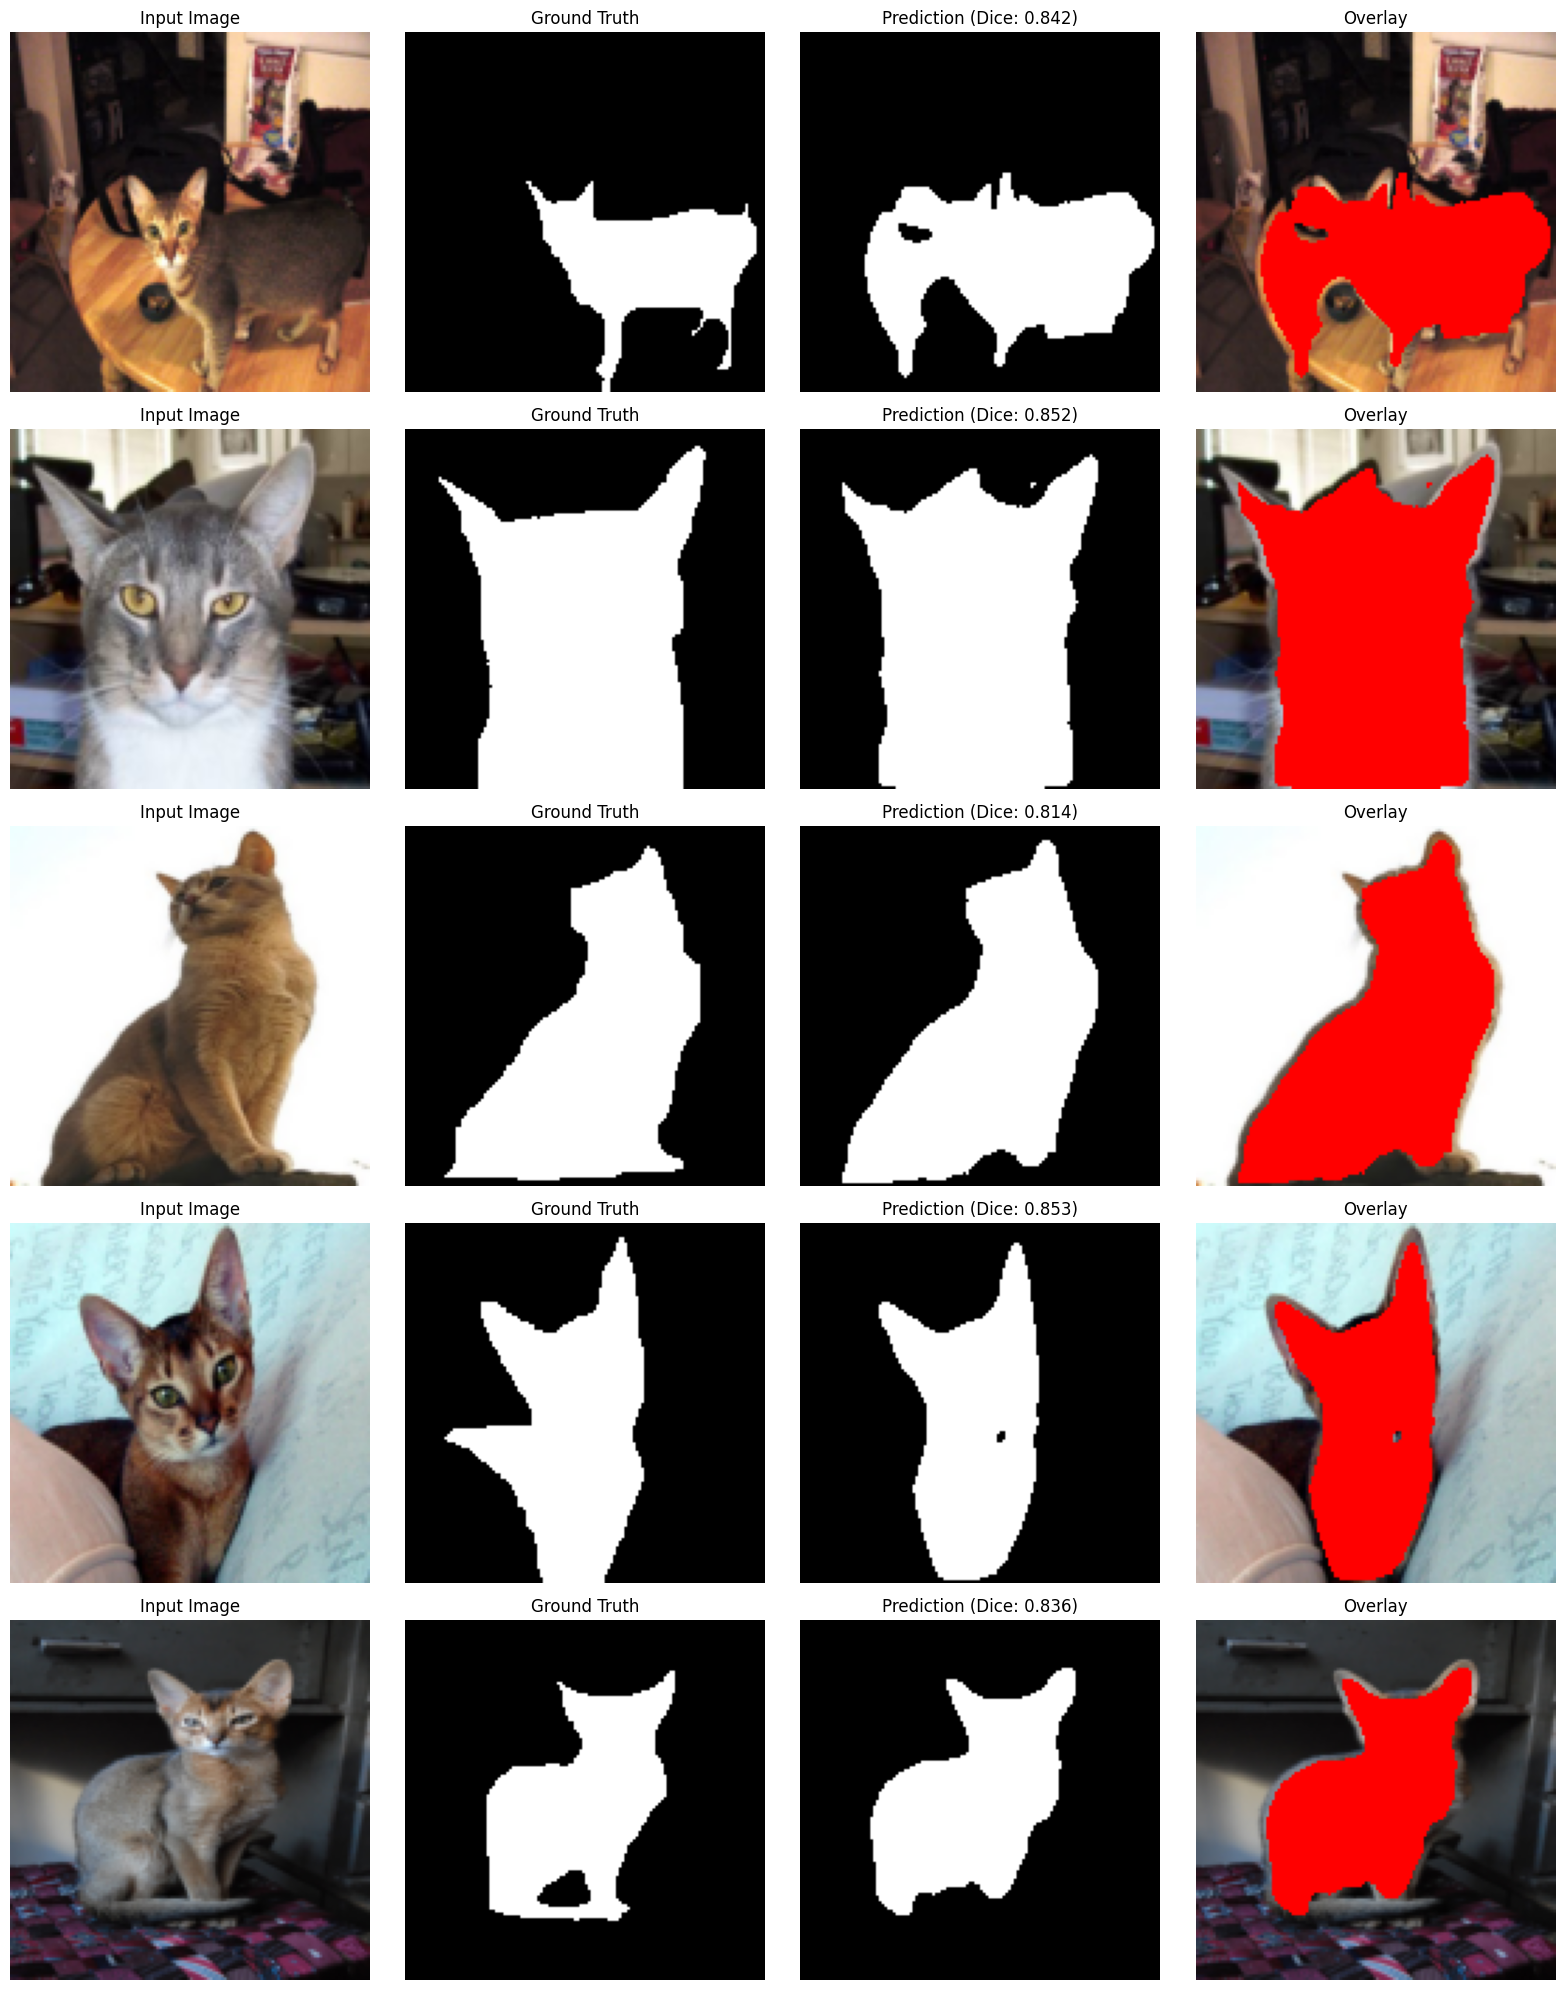

In [29]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Data transformations
img_size = 128
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transforms.Resize((img_size, img_size), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

# Create datasets
print("Loading datasets...")
trainval_dataset = OxfordPetsSegmentation(
    root='./data',
    split='trainval',
    transform=transform,
    target_transform=target_transform
)

test_dataset = OxfordPetsSegmentation(
    root='./data',
    split='test',
    transform=transform,
    target_transform=target_transform
)

# Split trainval dataset into train and validation
train_size = int(0.8 * len(trainval_dataset))
val_size = len(trainval_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    trainval_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {batch_size}")

# Create model
model = UNet(in_channels=3, out_channels=1, init_features=32).to(device)

# Print model summary
print("\nModel Architecture:")
print(model)

# Calculate total parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Train the model
print("\nStarting training...")
train_losses, val_losses, val_dices, val_ious = train_model(
    model, train_loader, val_loader, criterion, optimizer, 
    num_epochs=20, scheduler=scheduler
)

# Plot training history
plot_training_history(train_losses, val_losses, val_dices, val_ious)

# Load best model
if os.path.exists('best_unet_model.pth'):
    checkpoint = torch.load('best_unet_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"\nLoaded best model from epoch {checkpoint['epoch']+1}")
    print(f"Best validation Dice: {checkpoint['val_dice']:.4f}")
    print(f"Best validation IoU: {checkpoint['val_iou']:.4f}")

# Test the model
print("\nTesting on test set...")
model.eval()
test_loss = 0.0
test_dice = 0.0
test_iou = 0.0

test_bar = tqdm(test_loader, desc="Testing")
with torch.no_grad():
    for images, masks in test_bar:
        images = images.to(device)
        masks = masks.to(device)
        
        # Ensure masks have the right shape
        if len(masks.shape) == 3:
            masks = masks.unsqueeze(1)
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        dice = dice_coefficient(outputs, masks)
        iou = iou_score(outputs, masks)
        
        test_loss += loss.item() * images.size(0)
        test_dice += dice.item() * images.size(0)
        test_iou += iou.item() * images.size(0)
        
        test_bar.set_postfix({'loss': loss.item(), 'dice': dice.item()})

test_loss = test_loss / len(test_loader.dataset)
test_dice = test_dice / len(test_loader.dataset)
test_iou = test_iou / len(test_loader.dataset)

print(f"\nTest Results:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Dice: {test_dice:.4f}")
print(f"  Test IoU: {test_iou:.4f}")

# Visualize results
print("\nVisualizing results...")
visualize_results(model, test_loader, num_samples=5)